# Data Visualisation


## Number of the three viewing angles according to the sign

In [56]:
from PIL import Image, ImageOps
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os


# Load Label Studio annotations 
def load_labelstudio_annotations(json_path):
    records = []

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for task in data:
        # Handle local paths - assuming images are in 'data/' directory - WILL CHANGE LATER
        image_url = task.get("data", {}).get("image", "")
        # print(image_url)   
        image_filename = os.path.basename(image_url)
        local_path = os.path.join(
            r"label-studio\label-studio\media\upload\2",
            image_filename
        )
        # print(local_path)

        for ann in task.get("annotations", []):
            regions = {}
            for r in ann.get("result", []):
                region_id = r.get("id")
                if region_id not in regions:
                    regions[region_id] = {"image_path": local_path}
                regions[region_id][r["from_name"]] = r["value"]

            for region in regions.values():
                if "sign_type" in region:
                    records.append({
                        "sign_type": region["sign_type"]["rectanglelabels"][0],
                        "view_angle": region.get("view_angle", {}).get("choices", ["Unknown"])[0],
                        "image_path": region["image_path"],
                        "bbox": [region.get("sign_type", {}).get("x"), 
                                 region.get("sign_type", {}).get("y"), 
                                 region.get("sign_type", {}).get("width"), 
                                 region.get("sign_type", {}).get("height")]
                    })

    return pd.DataFrame(records)


# Load annotations
df = load_labelstudio_annotations("json_stefania.json")

# Sign Type vs Viewing Angle
summary_table = (
    df.groupby(["sign_type", "view_angle"])
      .size()
      .unstack(fill_value=0)
)

display(summary_table)
print(df["view_angle"].value_counts())


view_angle,Back,Front,Side
sign_type,,,
Blind-Spot Mirror (Convex),10,11,11
No Entry (One Way),21,24,27
No Through Road (T-Sign),4,3,3
Pedestrian Crossing,8,8,9
Roundabout Ahead,7,8,7
Stop,11,11,11


view_angle
Side     68
Front    65
Back     61
Name: count, dtype: int64


Note how some of the signs do not have equal front, back and side views. This is due to the fact that there are images which had some background signs which we decided to label as well, to have a higher reliable model that can be used as a good prototype.

## Distribution of sign types and viewing angles

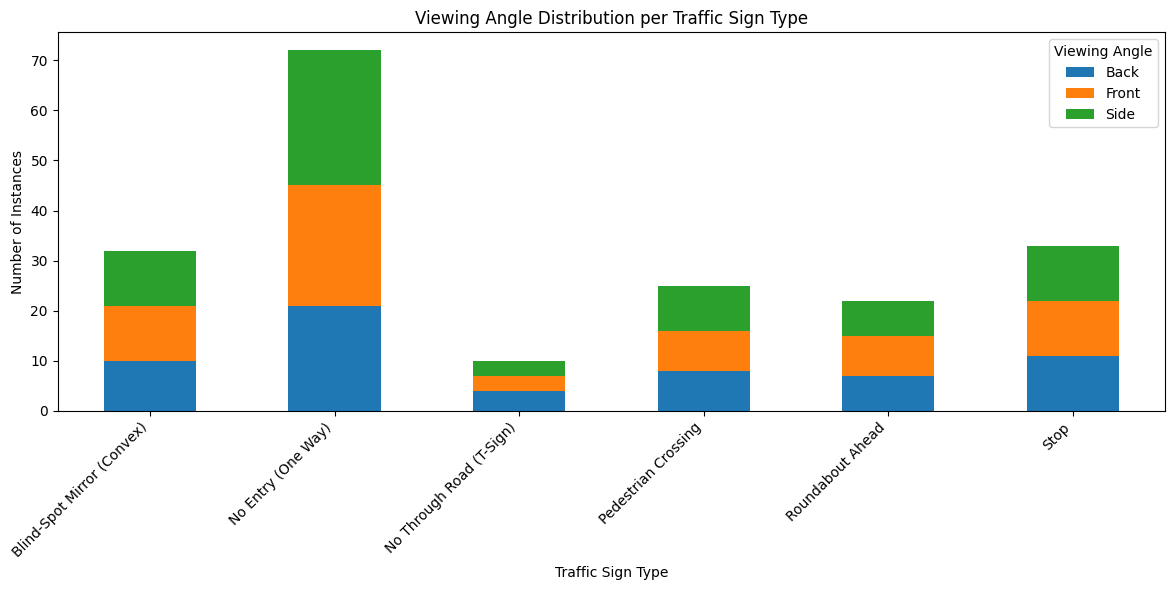

In [57]:
# Sign Type vs Viewing Angle Visualization
counts = (
    df.groupby(["sign_type", "view_angle"])
      .size()
      .unstack(fill_value=0)
)

counts.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6)
)

plt.title("Viewing Angle Distribution per Traffic Sign Type")
plt.xlabel("Traffic Sign Type")
plt.ylabel("Number of Instances")
plt.legend(title="Viewing Angle")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Visualisation of Annotated Images

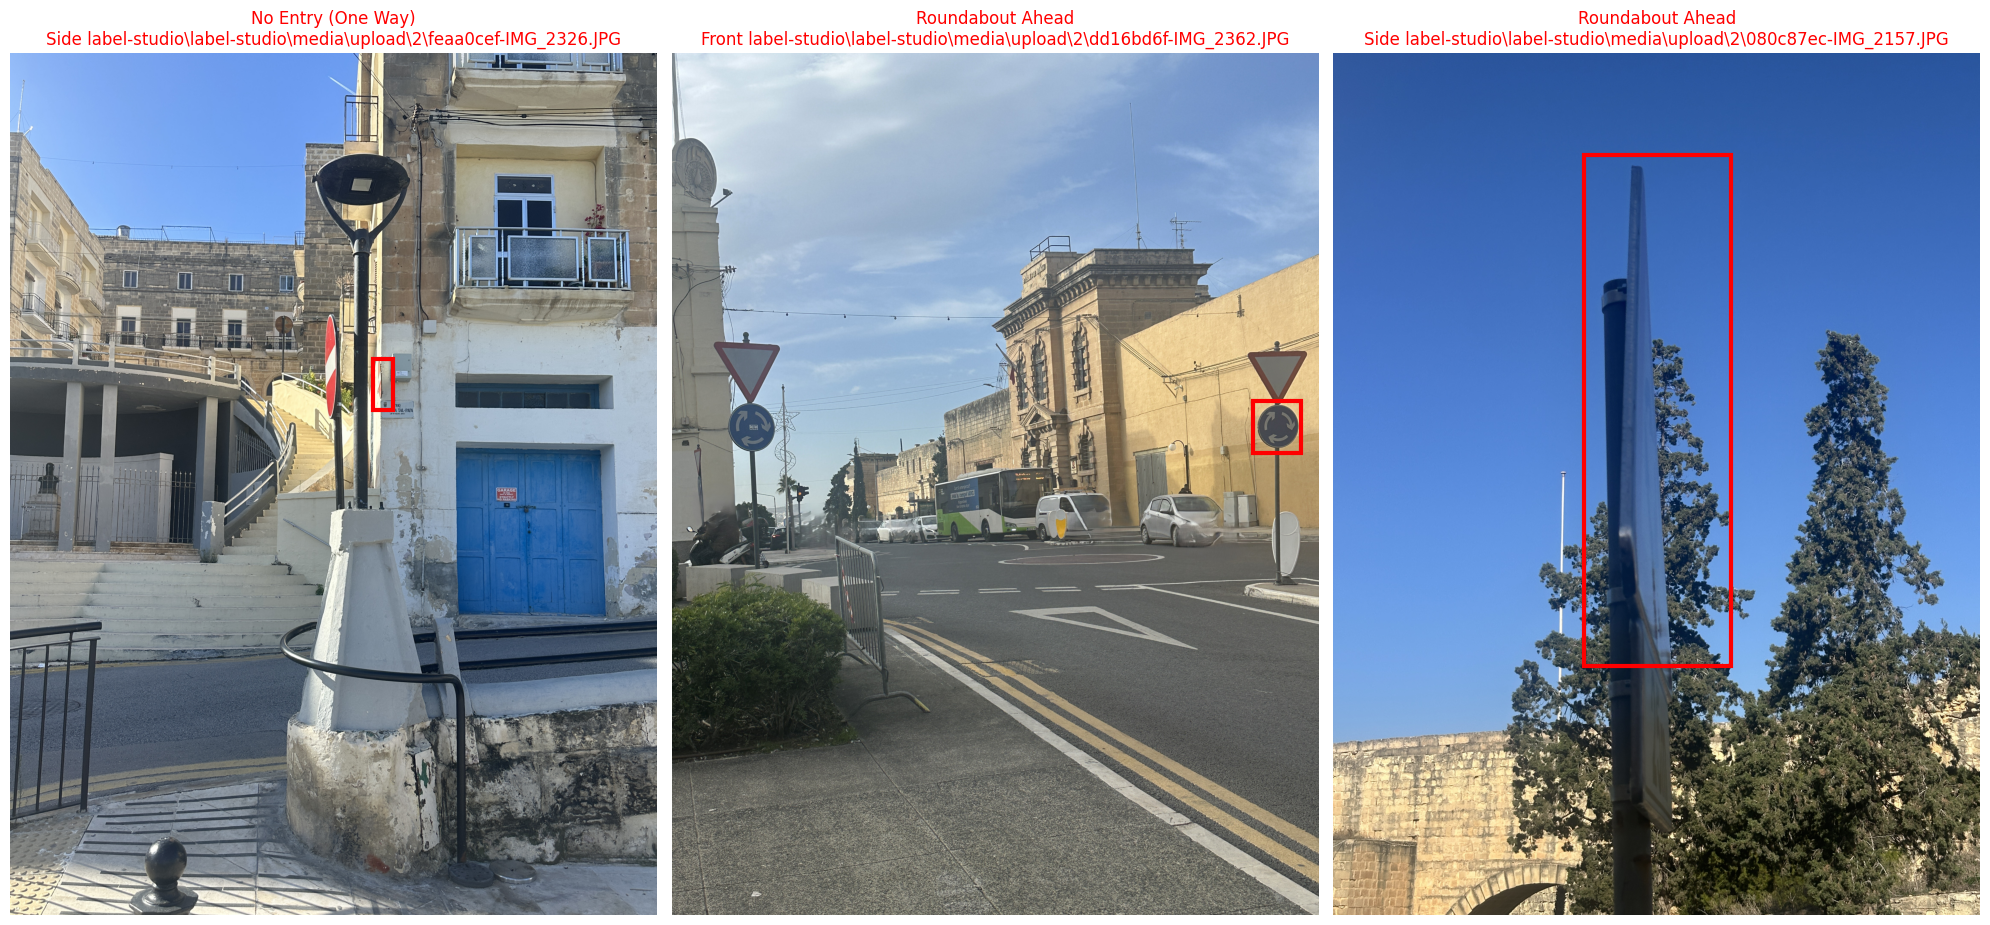

In [58]:
def visualize_samples(df, num_samples=3):
    samples = df.sample(min(num_samples, len(df)))
    fig, axes = plt.subplots(1, len(samples), figsize=(20, 10))
    
    if len(samples) == 1:
        axes = [axes]
        
    for i, (idx, row) in enumerate(samples.iterrows()):
        if os.path.exists(row['image_path']):
            img_raw = Image.open(row['image_path'])
            img_fixed = ImageOps.exif_transpose(img_raw)
            img = np.array(img_fixed)
            axes[i].imshow(img)
            
            # Label Studio coordinates are in percentages (0-100)
            h, w = img.shape[:2]
            x, y, bw, bh = row['bbox']
            
            if x is not None:
                px = x * w / 100
                py = y * h / 100
                pbw = bw * w / 100
                pbh = bh * h / 100
                
                rect = patches.Rectangle((px, py), pbw, pbh, linewidth=3, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect)
                axes[i].set_title(f"{row['sign_type']}\n{row['view_angle']} {row['image_path']}", color='red', fontsize=12)
        else:
            axes[i].text(0.5, 0.5, f"Image not found:\n{row['image_path']}", ha='center')
        
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


# print(df)
visualize_samples(df, num_samples=3)

## Splitting the dataset into train and test sets

In [59]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(images_dir, output_dir, train_ratio=0.8, seed=42):
    image_files = []
    for root, _, files in os.walk(images_dir):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                image_files.append(os.path.join(root, file))

    train_images, test_images = train_test_split(
        image_files, train_size=train_ratio, random_state=seed, shuffle=True
    )

    for split, split_images in {"train": train_images, "test": test_images}.items():
        out_dir = os.path.join(output_dir, split, "images")
        os.makedirs(out_dir, exist_ok=True)
        for src_path in split_images:
            shutil.copy(src_path, os.path.join(out_dir, os.path.basename(src_path)))
            
    print(f"Saved train/test split to: {output_dir}")

In [60]:
split_dataset(
    images_dir="label-studio/label-studio/media/upload/2",
    output_dir="data_split/",
    train_ratio=0.8,
)

Saved train/test split to: data_split/
